In [2]:
from datetime import date
date = date.today().strftime("%b_%d")

# Import packages
import torch
import numpy as np
import normflows as nf
import pandas as pd
import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from IPython.display import clear_output
import time
import os
def checkdir(path):
    if not os.path.exists(path): 
        os.makedirs(path)
        

In [7]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv("neutron_calorimeter_data.csv")

In [30]:
input_tensor = torch.from_numpy(df.values).to(torch.float32)
input_tensor

tensor([[301.1671,  27.2155],
        [240.5926,  56.8275],
        [251.5587,  51.1763],
        ...,
        [278.6509, 107.9012],
        [329.2931,  86.0532],
        [361.5293,  87.7276]])

In [140]:
indexes = torch.randperm(input_tensor.shape[0])
dataset = input_tensor[indexes] / 1000

In [142]:
train_frac = 0.8
test_frac = 0.1
val_frac = 0.1
train_lim = int(np.floor(dataset.shape[0] * train_frac))
test_lim = train_lim + int(np.floor(dataset.shape[0] * test_frac))
val_lim = test_lim + int(np.floor(dataset.shape[0] * val_frac))
train_data = dataset[:train_lim]
test_data = dataset[train_lim:test_lim]
val_data = dataset[test_lim:val_lim]

torch.save(train_data,"data/shuffled_train.pt")
torch.save(test_data,"data/shuffled_test.pt")
torch.save(val_data,"data/shuffled_val.pt")

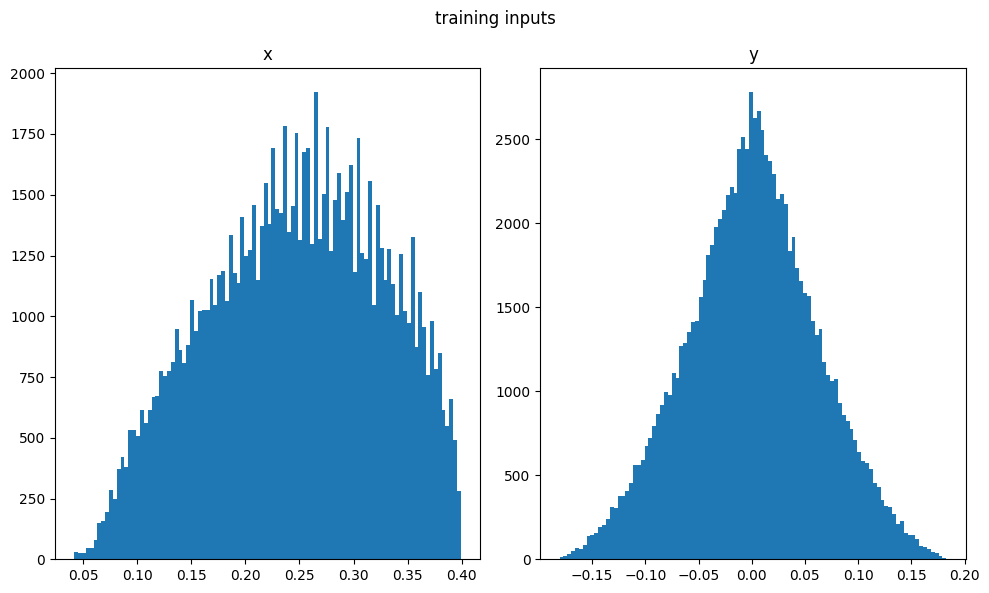

In [143]:
input_fig, input_axs = plot.subplots(1,2,figsize=(10,6))
input_fig.suptitle("training inputs")
input_axs[0].hist(train_data[:100000,0],bins = 100)
input_axs[0].set_title("x")
input_axs[1].hist(train_data[:100000,1],bins = 100)
input_axs[1].set_title("y")
input_fig.tight_layout()
# input_fig.savefig("plots/inputs_train_" + run_num_str+  ".jpeg")

In [170]:
run_num = 1

num_layers = 48
hidden_units = 64
batch_size = 128
lr = 1e-5
num_epochs = 8

latent_size = 2

#strings for file paths
lr_str = str(lr)
hidden_units_str = str(hidden_units)
num_layers_str = str(num_layers)
batch_size_str = str(batch_size)
run_num_str = str(run_num)

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, hidden_units, hidden_units, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.NormalizingFlow(base, flows)

# Move model on GPU if available
model = model.to(device)

In [171]:
import datetime

x = datetime.datetime.now()
today = x.strftime("%B_%d")

model_path = "models/" + today + "/"
checkdir(model_path)

loss_path = "plots/loss/" + today + "/"
checkdir(loss_path)

run_info = "run_" + run_num_str+ "_"+ K_str + "flows_" + num_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs"

In [172]:
# Train model
max_iter = int(np.floor(train_data.shape[0] / batch_size))
train_loss_hist = np.array([])
val_loss_hist = np.array([])
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

validation_frequency = 100  # Perform validation every 100 training steps
print("beginning training loop")
global_step = 0
for epoch in range(num_epochs):
    print(f"Beginning epoch #{epoch}")
    model.train()  # Set model to training mode
    for it in range(max_iter):
        optimizer.zero_grad()
        # Get training samples
        begin = it * batch_size
        end = (it + 1) * batch_size
        samples = train_data[begin:end].to(device)
        # Compute loss
        loss = model.forward_kld(samples)
        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        # Log loss
        train_loss_hist = np.append(train_loss_hist, loss.to('cpu').data.numpy())

        global_step += 1

        # Validation step every 100 training steps
        if global_step % validation_frequency == 0:
            model.eval()  # Set model to evaluation mode
            val_loss = 0
            val_iter = min(100, int(np.floor(val_data.shape[0] / batch_size)))  # Limit validation to 100 batches
            with torch.no_grad():
                for val_it in range(val_iter):
                    begin = val_it * batch_size
                    end = (val_it + 1) * batch_size
                    samples = val_data[begin:end].to(device)
                    loss = model.forward_kld(samples)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / val_iter
            val_loss_hist = np.append(val_loss_hist, avg_val_loss)
            
#             print(f"Step {global_step} - Train Loss: {train_loss_hist[-1]:.4f}, Val Loss: {avg_val_loss:.4f}")
            
            model.train()  # Set model back to training mode
    model.save(model_path + run_info + f"_checkpoint_e{epoch}.pth")
    print(f"Epoch {epoch} completed.")

beginning training loop
Beginning epoch #0
Epoch 0 completed.
Beginning epoch #1
Epoch 1 completed.
Beginning epoch #2
Epoch 2 completed.
Beginning epoch #3
Epoch 3 completed.
Beginning epoch #4
Epoch 4 completed.
Beginning epoch #5
Epoch 5 completed.
Beginning epoch #6
Epoch 6 completed.
Beginning epoch #7
Epoch 7 completed.


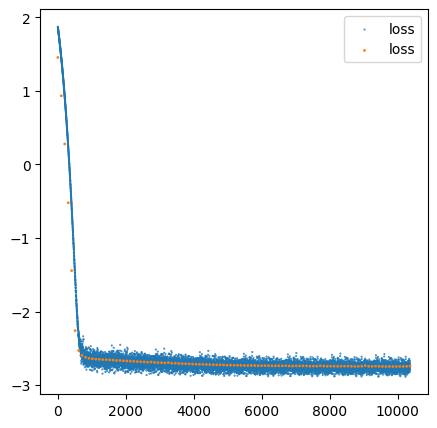

In [173]:
model.save(model_path + run_info + ".pth")
# Plot loss
plot.figure(figsize=(5, 5))
plot.scatter(range(len(train_loss_hist)),train_loss_hist, np.ones(len(train_loss_hist)) * 0.2, label='loss', alpha = 1)
plot.scatter(np.linspace(0,len(train_loss_hist),len(val_loss_hist)),val_loss_hist, np.ones(len(val_loss_hist)) * 1, label='loss', alpha = 1)
# plot.xlim(10000,11000)
plot.legend()
# plot.savefig( loss_path + run_info + ".jpeg")

## Inference

In [174]:
num_samples = 20000
batch_size = 1000
it = 0
num_batches = int(num_samples / batch_size)

In [175]:
begin_time = time.time()
samples = []
with torch.no_grad():
    for it in range(num_batches):
        batch_samples = model.sample(num_samples=batch_size)[0].cpu()
        samples.append(batch_samples)

samples = torch.cat(samples, dim=0)
end_time = time.time()
print(f"sampling took {end_time - begin_time} seconds")

sampling took 0.25919461250305176 seconds


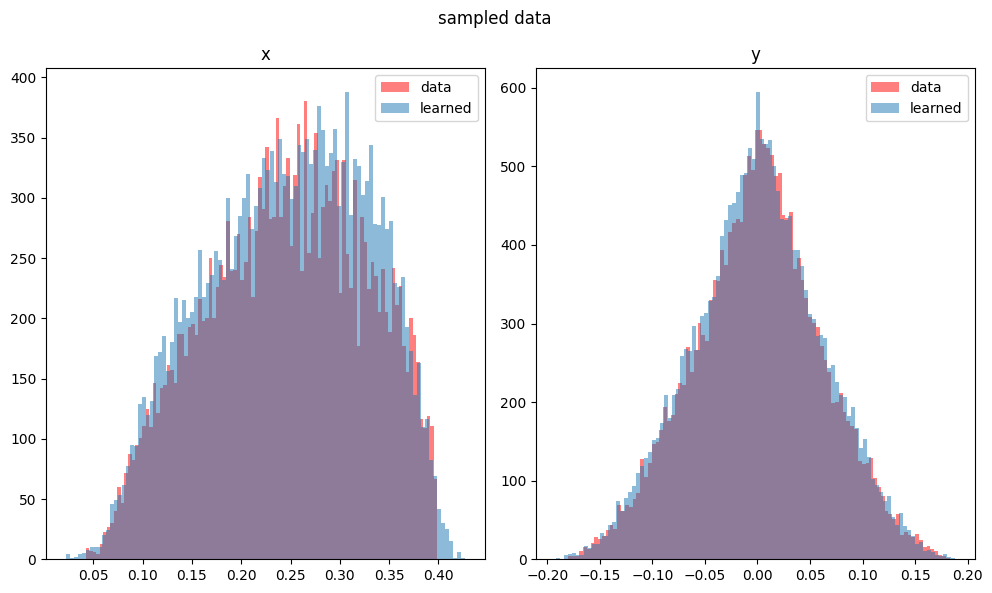

In [176]:
x_valid_samples = samples[:,0]
# x_valid_samples = x_valid_samples[~(torch.isinf(x_valid_samples) | torch.isnan(x_valid_samples))]
# x_valid_samples = x_valid_samples[(x_valid_samples > 0) & (x_valid_samples < 500)]
y_valid_samples = samples[:,1]
# y_valid_samples = y_valid_samples[~(torch.isinf(y_valid_samples) | torch.isnan(y_valid_samples))]
# y_valid_samples = y_valid_samples[(y_valid_samples > -500) & (y_valid_samples < 500)]

sample_fig, sample_axs = plot.subplots(1,2,figsize=(10,6))
sample_fig.suptitle("sampled data")
sample_axs[0].hist(train_data[:len(x_valid_samples),0],bins = 100,color = "r", alpha = 0.5,label = "data")
sample_axs[0].hist(x_valid_samples,bins = 100, alpha = 0.5,label = "learned")
sample_axs[0].set_title("x")
sample_axs[0].legend()
sample_axs[1].hist(train_data[:len(y_valid_samples),1],bins = 100,color = "r", alpha = 0.5,label = "data")
sample_axs[1].hist(y_valid_samples,bins = 100,alpha = 0.5,label = "learned")
sample_axs[1].set_title("y")
sample_axs[1].legend()
sample_fig.tight_layout()